# Local Linear Embedding

Author: Chris Nunn, Jeremy Rothschild

[Theory](#linkTheory)  <br>
[Example 1: The classic cinnamon bun](#linkExample1)  <br>
[Example 2: Faces](#linkExample2) <br>
 
[Resources](#linkResources)  

### Theory<a id='linkTheory'></a>

LLE is a nonlinear dimensionality reduction technique that relies on a simple geometrical argument:

Consider a set of $N$ vectors $\vec{X_i}$, of dimension $D$ sampled from some smooth manifold embedded in this space.

The local geometry of this manifold can be approximated arbitrarily well by the tangent space. Given that different neighbourhoods of points can have different geometry, LLE aims to interpolate between these local linear approximations to extract the global structure of this manifold. By learning the global coordinates of this manifold we have achieved some dimensionality reduction. 

#### Details

Local geometry in the $D$ dimensional space can be described by a set of coefficients that reconstruct points through a linear combination of their neighbors. In this sense, the reconstruction error (our cost function) is given by:


$$\epsilon = \sum_i| \vec{X_i} - \sum_j W_{ij}\vec{X_j}|^2$$ (i)

Where $W_{ij}$ are weights which represent the contribution of neighbour $j$  in reconstructing the point labeled $i$. 

We can calculate the 'best' weights (best linear description of local geometry) by minimizing this cost function with respect to these weights, subject to two constraints:

(1) $W_{ij}= 0$ if $\vec{X_j}$ does not belong to the set of neighbours of $\vec{X_i}$. This is just enforcing 'local' in 'local geometry'.

(2) $\sum_j W{ij}=1$. So that $W$ looks like a stochastic matrix (which might be useful to connect this to diffusion map). Note also that this constraint applies only to a specific row, so the weights can be calculated independently for each point.

This second constraint makes equation (i) invariant to translations. By construction it is also invariant to rotation and scaling.

Why impose this second constraint? Imagine that the data is sampled from a manifold of dimension $d \lt \lt D$. For points on or near a sufficiently small patch of the manifold, there exists to some approximation a linear mapping between these coordinates and the global coordinates of the manifold. 

If $W_{ij}$ describe the intrinsic local geometry, then for a linear mapping involving translations, rotations, and scaling, the same weights should describe the local geometry of the embedded manifold because they are invariant to these transformations. So our objective now is to find these global coordinates that are best reconstructed by our weights calculated in the previous step.

The reconstruction error in the $d$ dimensional space is then:

$$ \phi=\sum_i |\vec{Y_i} - \sum_j W_{ij}\vec{Y_j}|^2$$

Where $\vec{Y_i}$ represents the point $\vec{X_i}$ mapped to the global manifold coordinates. We now wish to minimize this reconstruction error with respect to these coordinates, $\vec{Y_i}$, keeping $W_{ij}$ fixed, as calculated in (i). This minimization can be performed by solving an NxN eigenvector problem, where the bottom $d$ eigenvectors of the matrix provide the set of orthogonal coordinates.

#### As a summary, the LLE algorithm:

1. Compute neighbors of $\vec{X_i}$
2. Compute the weights $W_{ij}$ that best reconstruct each data point $\vec{X_i}$ from it's neighbors, minimzing the cost function $\epsilon=\sum_i |\vec{X_i} - \sum_j W_{ij}\vec{X_j}|^2$ with constraints.
3. Compute the (lower dimensional) vectors $\vec{Y_i}$ best reconstructed by the weights $W_{ij}$, minimzing the cost function $\phi=\sum_i |\vec{Y_i} - \sum_j W_{ij}\vec{Y_j}|^2$, which is equivalent to solving an eigenvector problem.

#### Calculating Weights

Consider the reconstruction error for a single point $\vec{X_i}$ with $k$ nearest neighbours $\eta_j$:

$$\epsilon_i = | \vec{X_i} - \sum_jW_{j}\vec{\eta_j}|^2 = |\sum_jW_{j}(\vec{X_i}- \vec{\eta_j})|^2 = \sum_j W_j (\vec{X_i}-\vec{\eta_j}) \cdot \sum_k W_k (\vec{X_i}-\vec{\eta_k})$$

Like in the paper, can conveniently define the local covariance matrix by:

$$C_{jk} = (\vec{X_i} - \vec{\eta_j}) \cdot (\vec{X_i} - \vec{\eta_k})$$

So:

$$\epsilon_i = \sum_{j,k} W_{j}W_{k}C_{jk}$$

Switching to matrix notation to minimize this. Here we impose the $\sum_j W_{ij}=1$ constraint with a Lagrange multiplier as in the paper:

$$L = \boldsymbol{W^T}\boldsymbol{C}\boldsymbol{W} - \lambda (\boldsymbol{1}^T\boldsymbol{W} -1) = 0$$


Where $\boldsymbol{W}$ is a column vector. Taking the derivatives give:

$$\frac{\partial L}{\partial \boldsymbol{W}} = 2\boldsymbol{C}\boldsymbol{W} - \lambda\boldsymbol{1}=0$$

$$\frac{\partial L}{\partial \lambda} = -\boldsymbol{1}^T\boldsymbol{W} +1=0$$

So $\boldsymbol{W} = \frac{\lambda \boldsymbol{C}^{-1}\boldsymbol{1}}{2}$, and $\lambda$ can be set to impose the constraint. 

#### Calculating Weights (for k > D):

More unknown weights than equations, so one can do L2 regularization, meaning we are minimizing the following with respect to the weights:

$$\epsilon_i = | \vec{X_i} - \sum_jW_{j}\vec{\eta_j}|^2 + \alpha \sum_j {W_j}^2$$

#### Calculating Coordinates:

The objective is to minimize $\phi$ with respect to the global manifold coordinates $\vec{Y_i}$.

$$ min_Y   \phi=\sum_i |\vec{Y_i} - \sum_j W_{ij}\vec{Y_j}|^2$$

Subject to two constraints:

(1)  $\sum_i \vec{Y_i} = \vec{0}$. Imposing this constraint gives us a single solution, from a set of inifinite solutions because we could always translate our global coordinates by an arbitrary constant vector.

(2)  $\frac{1}{N}\sum_i\vec{Y_i}\vec{Y_i}^T = \boldsymbol{I}$. So this is the assumption that each component of the global coordinates contribute equally to reconstruction errors.

First consider the simple case where $d=1$, so $\boldsymbol{Y}$ is $Nx1$:

$$\phi = \boldsymbol{Y}^T\boldsymbol{Y} - \boldsymbol{Y}(\boldsymbol{WY})^T - (\boldsymbol{WY})^T \boldsymbol{Y} + (\boldsymbol{WY})^T \boldsymbol{WY}$$

$$=   (\boldsymbol{Y} -  \boldsymbol{WY})^T (\boldsymbol{Y} -  \boldsymbol{WY})$$

$$= \boldsymbol{Y}^T(\boldsymbol{I} - \boldsymbol{W})^T (\boldsymbol{I} - \boldsymbol{W})\boldsymbol{Y}$$

$$= \boldsymbol{Y}^T\boldsymbol{M}\boldsymbol{Y}$$

Where $ \boldsymbol{M} = (\boldsymbol{I} - \boldsymbol{W})^T (\boldsymbol{I} - \boldsymbol{W})$ is an $NxN$ matrix.

Using a Lagrange multiplier to enforce both of these constrains:

$$L = \boldsymbol{Y}^T\boldsymbol{M}\boldsymbol{Y} - \beta(N^{-1}\boldsymbol{Y}^T\boldsymbol{Y}- 1) - \gamma(\boldsymbol{CY})$$

Where $\boldsymbol{C} $ is an $NxN$ matrix that centers coordinates at the origin. Taking derivatives:

$$\frac{\partial L}{\partial \boldsymbol{Y}} = 2\boldsymbol{M}\boldsymbol{Y} - \lambda(2N^{-1}\boldsymbol{Y}) -\gamma \boldsymbol{C}= 0$$

$$\frac{\partial L}{\partial \beta} = N^{-1}\boldsymbol{Y}^T\boldsymbol{Y}- 1 = 0$$

$$\frac{\partial L}{\partial \gamma} = \boldsymbol{CY} = 0$$

So,

$$\boldsymbol{M}\boldsymbol{Y} = \frac{\lambda}{N}\boldsymbol{Y}$$

Where we are free to choose $\gamma= 0$.

So $\boldsymbol{Y}$ is an eigenvector of $\boldsymbol{M}$. Now which eigenvectors are important? Because we are minimizing $ \boldsymbol{Y}^T\boldsymbol{M}\boldsymbol{Y}$ we want the eigenvectors corresponding to the smallest eigenvalues. Because $\boldsymbol{1}$ is an eigenvector of $\boldsymbol{M}$ with eigenvalue zero, we take the $d + 1$ bottom eigenvectors and discard the constant eigenvector as the global coordinates. (This is the opposite of PCA, because we are minimizing reconstruction error, and not maximizing covariance).

Extending this to $d > 1$, all we do is calculate more bottom eigenvectors of $\boldsymbol{M}$ to add more global coordinates.

#### Discussion
(1) Conditions under which LLE fails?

(2) Advantages/disadvantages compared to IsoMap?

#### Code

In the following sections we have written some examples of LLE.

### Example 1: The Swiss Roll Revisited<a id='linkExample1'></a>

In [3]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
#Axes3D

In [2]:
n_points = 1000
X, color = datasets.s
amples_generator.make_swiss_roll(n_points, random_state=0)
n_neighbors = 10
n_components = 2

AttributeError: 'module' object has no attribute 's'

In [4]:
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)


ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    embedding = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method)
    Y = embedding.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

NameError: name 'n_neighbors' is not defined

<Figure size 1080x576 with 0 Axes>

8 neighbors: 0.52 sec
10 neighbors: 0.5 sec
11 neighbors: 0.82 sec
12 neighbors: 0.55 sec
15 neighbors: 0.49 sec
20 neighbors: 0.57 sec
25 neighbors: 0.6 sec
30 neighbors: 0.59 sec
50 neighbors: 0.77 sec


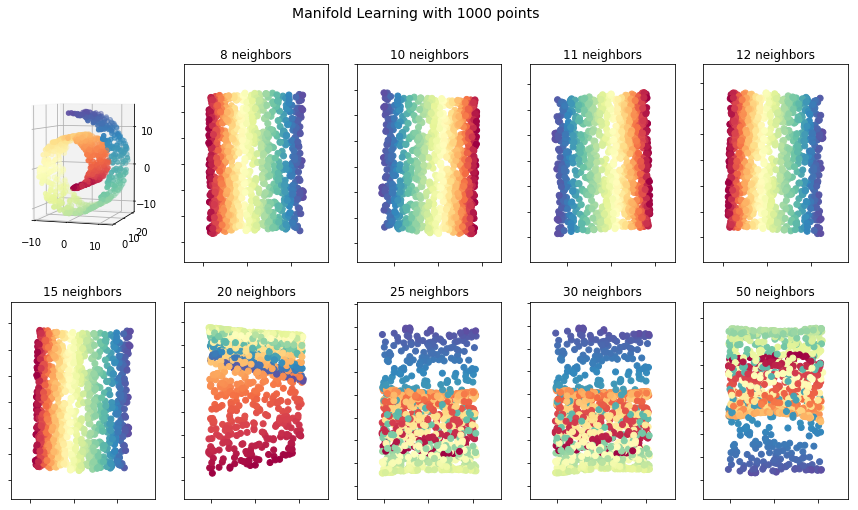

In [35]:

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points"
             % (1000), fontsize=14)
n
N_neighbors = [ 8, 10, 11, 12, 15, 20, 25, 30, 50]

ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

method = methods[3] 

for i, num_neigh in enumerate(N_neighbors):
    t0 = time()
    embedding = manifold.LocallyLinearEmbedding(num_neigh, n_components,
                                        eigen_solver='auto',
                          
                                                method=method)
    Y = embedding.fit_transform(X)
    t1 = time()
    print("%s neighbors: %.2g sec" % (num_neigh,n t1 - t0))

    ax = fig.add_subplot(2, 5 , i+2) 
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s neighbors" % (num_neigh))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

### Example 2: Faces<a id='linkExample2'></a>

### Resources<a id='linkResources'></a>

[classic paper](https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf)